In [1]:
import numpy as np
from scipy.special import factorial as sp_factorial, erfinv
from matplotlib import pyplot as plt

import logging, os

from ultranest.plot import cornerplot

from placefield_dynamics.placefield_detection import *

os.environ['OMP_NUM_THREADS'] = '1'
ultranest.__version__

logging.basicConfig(level=logging.INFO)

2024-05-22 09:23:56.894790: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 09:23:56.918157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def tuning_curve(x_arr,p):

    """
        defines the model by providing the average expected firing rate at each bin
    """
    x_max = x_arr.shape[0]

    if len(p.shape)==1:
        p = p[np.newaxis,:]
    p = p[...,np.newaxis,np.newaxis]   ## adding 2 axes for 1. number of trials, 2. number of bins
    
    mean_model_nofield = np.ones((p.shape[0],x_max))*p[:,0,:,0]
    mean_model_field = np.ones((p.shape[0],p.shape[1]-4,x_max))*p[:,0,...]
    if p.shape[1] > 1:
        for j in [-1,0,1]:
            mean_model_field += \
                (p[:,1,...]*np.exp(
                        -(x_arr[np.newaxis,np.newaxis,:] - p[:,3,...] - p[:,4:,:,0] + x_max*j)**2/(2*p[:,2,...]**2)
                    )
                )

    return mean_model_nofield, mean_model_field

def poisson_spikes(nu,N,T_total):
    return np.exp(N*np.log(nu*T_total) - np.log(sp_factorial(N)) - nu*T_total)

def poisson_spikes_log(nu,N,T_total):
    return N*np.log(nu*T_total) - np.log(sp_factorial(N)) - nu*T_total

In [3]:
from scipy.ndimage import binary_opening, gaussian_filter1d as gauss_filter

class HierarchicalBayesModel:

  ### possible speedup through...
  ###   parallelization of code

    def __init__(self, N, dwelltime, x_arr, hierarchical=False, logLevel=logging.ERROR):
        #self.N = gauss_filter(N,2,axis=1)
        self.N = N[np.newaxis,...]
        self.dwelltime = dwelltime[np.newaxis,...]
        self.nTrials, self.nbin = N.shape
        self.x_arr = x_arr[np.newaxis,np.newaxis,:]
        self.x_max = x_arr.max()
        self.Nx = len(x_arr)
        
        self.hierarchical = hierarchical
        
        self.f = 1

        
        self.set_priors()
                
        self.min_trials = 3
        
        self.log = logging.getLogger("nestLogger")
        self.log.setLevel(logLevel)

    def transform_p(self,p_in):
        
        if len(p_in.shape)==1:
            p_in = p_in[np.newaxis,...]
        #print(p_in)
        p_out = np.zeros_like(p_in)
        
        ct = 0
        #for j,p in enumerate(p_in.T):
        
        for key in self.priors:
            
            p_out[:,ct] = self.priors[key]['transform'](p_in[:,ct])
            ct += 1
            
            if self.priors[key]['hierarchical']:
                p_out[:,ct:ct+self.nTrials] = self.priors[key]['hierarchical']['transform'](p_in[:,ct:ct+self.nTrials])
                ct += self.nTrials
            
            #else:
            #    p_out[:,j] = self.priors[key]['hierarchical']['transform'](p)
                
                #print(key,p_in[i],p_ref + p_out[i])
                #p_ref = p_out[:,self.priors[key]['idx']]
                
                #if key=='theta':
                #    p_out[:,i] = np.mod(p_ref+p_out[:,i],self.Nx) - p_ref
                
                #else:
                #    for j in np.where((p_ref+p_out[:,i])<0):
                #        p_out[j,i] = -p_ref[j] + 0.01                    
                
                #print('new:',key,p_in[:,i],p_ref + p_out[:,i])
                
        return p_out

    
    def set_priors(self):
        
        halfnorm_ppf = lambda x, loc, scale: loc + scale * np.sqrt(2) * erfinv(x)
        #halfnorm_ppf = sstats.halfnorm.ppf
        
        norm_ppf = lambda x, loc, scale: loc + scale * np.sqrt(2) * erfinv(2*x - 1)
        #norm_ppf = sstats.norm.ppf
        
        self.priors = {
            'A0': {
                'params':       {'loc':0., 'scale':2},
                'function':     halfnorm_ppf,
                'hierarchical': {
                    'n':           self.nTrials,
                    'params':      {'loc':0, 'scale':1},
                    'function':    norm_ppf,
                } 
            },
            'A': {
                'params':       {'loc':1, 'scale':5},
                'function':     halfnorm_ppf,
                'hierarchical': {
                    'n':            self.nTrials,
                    'params':       {'loc': 0, 'scale': 2},
                    'function':     norm_ppf,
                } 
            },
            
            'sigma': {
                'params':       {'loc': 0.2, 'scale': 1},
                'function':     halfnorm_ppf,
                'hierarchical': {
                    'n':            self.nTrials,
                    'params':       {'loc':0, 'scale':1},
                    'function':    norm_ppf
                } 
            },
            'theta': {
                'params':       {'stretch': self.Nx},
                'function':     lambda x,stretch: x*stretch,
                'hierarchical': {
                    'n':            self.nTrials,
                    'params':       {'loc': 0, 'scale': 1},
                    'function':     norm_ppf,
                } 
            },
        }
        
            
        
        for key in self.priors:
            self.priors[key]['transform'] = \
                lambda x,fun=self.priors[key]['function'],params=self.priors[key]['params']: fun(x,**params)
            
            #print(self.priors[key]['transform'])
            
            if not self.hierarchical:
                self.priors[key]['hierarchical'] = False
            elif self.priors[key]['hierarchical']:
                self.priors[key]['hierarchical']['transform'] = \
                    lambda x,fun=self.priors[key]['hierarchical']['function'],params=self.priors[key]['hierarchical']['params']: fun(x,**params)
            
            
            
        
        self.paraNames = []
        ct = 0
        for key in self.priors:
            
            self.paraNames.append(key)
            self.priors[key]['idx'] = ct
            ct += 1
            if self.priors[key]['hierarchical']:
                for i in range(self.priors[key]['hierarchical']['n']):
                    self.paraNames.append(f'{key}_{i}')
                ct += self.priors[key]['hierarchical']['n']
        
        self.nPars = len(self.paraNames)
        self.pTC = {}
        self.pTC['wrap'] = np.zeros(self.nPars).astype('bool')
        self.pTC['wrap'][self.priors['theta']['idx']] = True

        
    def set_logl_func(self,vectorized=True):

        '''
            TODO:
                instead of finding correlated trials before identification, run bayesian 
                inference on all neurons, but adjust log-likelihood:

                    * take placefield position, width, etc as hierarchical parameter 
                        (narrow distribution for location and baseline activity?)
                    * later, calculate logl for final parameter set to obtain active-trials (better logl)
                
                make sure all of this runs kinda fast!

                check, whether another hierarchy level should estimate noise-distribution parameters for overall data 
                    (thus, running inference only once on complete session, with N*4 parameters)
        '''
        
        self.fields = np.zeros(self.nTrials)
        def get_logl(p_in,plt_bool=False):
            
            if len(p_in.shape)==1:
                p_in = p_in[np.newaxis,:]
            N_in = p_in.shape[0]
            
            ## get proper parameters from p_in
            params = {}
            dParams_trial_from_total = np.zeros((N_in,self.nTrials))
            for key in self.priors:
                if self.priors[key]['hierarchical']:
                    params[key] = p_in[:,self.priors[key]['idx'],np.newaxis] + \
                       p_in[:,self.priors[key]['idx']+1:self.priors[key]['idx']+1+self.nTrials]
                    
                    if key=='theta':
                        params[key] = np.mod(params[key],self.Nx)
                        self.log.debug(('p_in:',p_in[:,self.priors[key]['idx']+1:self.priors[key]['idx']+1+self.nTrials]))

                    dParams_trial_from_total += (p_in[:,self.priors[key]['idx']+1:self.priors[key]['idx']+1+self.nTrials]/self.priors[key]['hierarchical']['params']['scale'])**2
                else:
                    params[key] = p_in[:,self.priors[key]['idx'],np.newaxis]
                
                params[key] = params[key][...,np.newaxis]
                self.log.debug((f'{key}:',np.squeeze(params[key])))            
                self.log.debug((f'{key}:',params[key].shape))            
            
            
            self.log.debug(('dParams squared:',dParams_trial_from_total))
            
            ## build tuning-curve model
            mean_model_nofield = np.ones((N_in,self.nTrials,self.Nx))*params['A0']#[...,0]
            mean_model_field = np.ones((N_in,self.nTrials,self.Nx))*params['A0']#[...,0]
            if N_in > 1:
                for j in [-1,0,1]:
                    mean_model_field += \
                        (params['A']*np.exp(
                                -(self.x_arr - params['theta'] + self.x_max*j)**2/(2*params['sigma']**2)
                            )
                        )
            
            ## get probability to observe N spikes (amplitude) within dwelltime for each bin in each trial
            logp_nofield_at_position = poisson_spikes_log(mean_model_nofield,self.N,self.dwelltime)
            logp_field_at_position = poisson_spikes_log(mean_model_field,self.N,self.dwelltime)
            ## fix 0-entries in probabilities (should maybe be done)
            logp_nofield_at_position[np.isnan(logp_nofield_at_position)] = -1
            logp_field_at_position[np.isnan(logp_field_at_position)] = -1
            #p_field_at_position[p_field_at_position==0] = np.exp(-200)
            #self.log.debug((('nofield:',logp_nofield_at_position)))
            #self.log.debug((('field:',logp_field_at_position)))
            
            logp_trials = np.zeros((2,N_in,self.nTrials))
            logp_trials[0,...] = np.nansum(logp_nofield_at_position,axis=2)
            logp_trials[1,...] = np.nansum(logp_field_at_position,axis=2)

            # consider trials to be place-coding, when bayesian information criterion (BIC) 
            # is lower than nofield-model. Number of parameters for each trial is 1 vs 4, 
            # as trial dependent parameters only affect a single trial, each
            BIC_nofield = 1 * np.log(self.Nx) - 2 * logp_trials[0,...]
            BIC_field = 4 * np.log(self.Nx) - 2 * logp_trials[1,...]
            
            field_in_trial = BIC_field < BIC_nofield
            
            discount = np.sqrt((dParams_trial_from_total*(1+field_in_trial)).sum(axis=1))/self.nTrials
            
            self.fields += field_in_trial.sum(axis=0)
            
            
            self.log.debug(field_in_trial)
            self.log.debug(~field_in_trial)
            
            # only consider the cell to be place coding, if at least min_trials are place-coding
            logp = np.zeros(N_in)
            for i in range(N_in):
                #if field_in_trial[i,:].sum()>=self.min_trials:
                
                #logp[i] = logp_trials[i,~field_in_trial[i,:],0].sum()
                #logp[i] += -50 * dParams_trial_from_total[i,~field_in_trial[i,:]].sum()

                ## for all non-field-trials, introduce "pull" towards 0 for all parameters to avoid flat posterior
                #logp[i] = (logp_trials[0,i,~field_in_trial[i,:]] * \
                #        (1 + dParams_trial_from_total[i,~field_in_trial[i,:]])).sum()
                #
                #logp[i] += logp_trials[1,i,field_in_trial[i,:]].sum()
                
                logp[i] = logp_trials[0,i,~field_in_trial[i,:]].sum()
                logp[i] += logp_trials[1,i,field_in_trial[i,:]].sum()
                logp[i] += -10 * discount[i]
            
                
                self.log.debug((f'logp trials {i}:',logp_trials[0,i,:]))#
                #nf = logp_trials[i,~field_in_trial[i,:],0] * \
                #        (1+dParams_trial_from_total[i,~field_in_trial[i,:]])                
                #self.log.debug(('nofield loglikelihood',nf.shape,nf))
                
                self.log.debug(('discount: ',dParams_trial_from_total[i,~field_in_trial[i,:]].sum()))
                self.log.debug((f'logp sum (with discount) {i}:',logp[i]))
                    
                #else:
                #    self.log.debug(('discount: ',dParams_trial_from_total[i,:].sum()))
                #    logp[i] = logp_trials[i,:,0].sum()
                #    logp[i] += -50 * dParams_trial_from_total[i,:].sum()
                    #logp[i] = (logp_trials[i,:,0] * \
                    #           (1+dParams_trial_from_total[i,:])).sum()
                
            if plt_bool:
                fig,ax = plt.subplots(3,N_in,figsize=(10,5))

                ax[0][0].plot(self.x_arr[0,0,:],self.N[0,...].T)
                ax[0][1].plot(self.x_arr[0,0,:],self.dwelltime[0,...].T)

                for i in range(N_in):
                    
                    ax[1][i].plot(self.x_arr[0,0,:],mean_model_nofield[i,...].T,linewidth=0.3)
                    ax[1][i].plot(self.x_arr[0,0,:],mean_model_field[i,...].T,linewidth=0.3)
                    
                    ax[1][i].plot(self.x_arr[0,0,:],mean_model_nofield[i,~field_in_trial[i,:],:].T)
                    ax[1][i].plot(self.x_arr[0,0,:],mean_model_field[i,field_in_trial[i,:],:].T)

                    ax[2][i].plot(self.x_arr[0,0,:],logp_nofield_at_position[i,~field_in_trial[i,...],:].T,linewidth=0.5)
                    ax[2][i].plot(self.x_arr[0,0,:],logp_field_at_position[i,field_in_trial[i,...],:].T,linewidth=1.5)

                plt.show()
            
            return logp

        return get_logl


## Load data from behavior and activity

In [4]:
import os
from placefield_dynamics.placefield_detection.utils import *
pathSession = '../data/556wt/Session12'
pathBehavior = os.path.join(pathSession,'aligned_behavior.pkl')
pathActivity = os.path.join(pathSession,'CaImAn_complete.hdf5')

neuron = 551
ld = load_dict_from_hdf5(pathActivity)
#S = gauss_filter(ld['S'][neuron,:],2)
S = ld['S'][neuron,:]


with open(pathBehavior,'rb') as f_open:
    ld = pickle.load(f_open)

nbin = 40
behavior = prepare_behavior(ld['time'],ld['position'],ld['reward_location'],nbin=nbin,f=15)
activity = prepare_activity(S,behavior['active'],behavior['trials'],nbin=nbin)

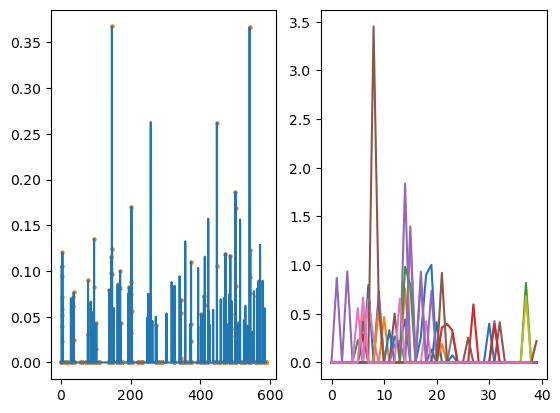

In [5]:
#%matplotlib nbagg 
fig,ax = plt.subplots(1,2)
ax[0].plot(ld['time'],S)
ax[0].scatter(behavior['time'],activity['S'],s=5,color='tab:orange')
ax[1].plot(activity['trial_map'].T)
plt.show()

In [6]:
hbm = HierarchicalBayesModel(
    activity['trial_map'],
    behavior['trials']['dwelltime'],
    np.arange(nbin),
    hierarchical=False,
    logLevel=logging.ERROR
)

my_prior_transform = hbm.transform_p
my_likelihood = hbm.set_logl_func()

print(hbm.paraNames)
sampler = ultranest.ReactiveNestedSampler(
    hbm.paraNames, 
    my_likelihood, my_prior_transform,
    wrapped_params=hbm.pTC['wrap'],
    vectorized=True,num_bootstraps=20,
    ndraw_min=512
)

num_samples = 400
#sampler.stepsampler = ultranest.stepsampler.SliceSampler(
#    nsteps=100,
#    generate_direction=ultranest.stepsampler.generate_cube_oriented_direction,
#)

#sampler.stepsampler = ultranest.stepsampler.SliceSampler(nsteps=hbm.nPars)
#         generate_direction=ultranest.stepsampler.generate_region_oriented_direction)
#sampler.stepsampler = ultranest.stepsampler.RegionSliceSampler(nsteps=hbm.nPars)#, adaptive_nsteps='move-distance')
#num_samples = 200

sampling_result = sampler.run(
    min_num_live_points=num_samples,
    max_iters=10000,cluster_num_live_points=20,max_num_improvement_loops=3,
    #region_class=ultranest.mlfriends.SimpleRegion(),
    show_status=True)#,viz_callback=False)  ## ... and run it #max_ncalls=500000,(f+1)*100,


['A0', 'A', 'sigma', 'theta']


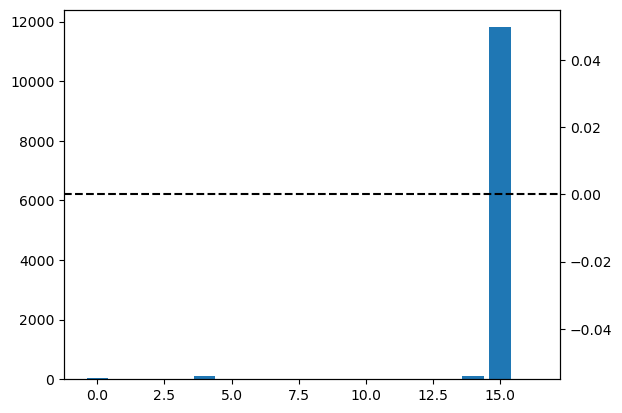

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(hbm.nTrials),hbm.fields)

ax2 = ax.twinx()
ax2.axhline(0,color='k',linestyle='--')
ax2.plot(sampling_result['posterior']['mean'][4:],'ok')
plt.show()
#hbm.fields.astype('int')

In [9]:
sampler.print_results()

sampler.plot()
sampler.plot_trace()


logZ = -140.587 +- 0.165
  single instance: logZ = -140.587 +- 0.131
  bootstrapped   : logZ = -140.585 +- 0.164
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    A0                  : 0.081 │ ▁▁  ▁▁▁▂▃▃▄▆▇▇▇▇▇▇▅▄▄▂▂▂▁▁▁▁▁▁▁▁▁   ▁ │0.538     0.273 +- 0.049
    A                   : 1.0   │▁▁▁▂▃▄▅▅▆▇▇▇▆▆▆▆▆▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁ ▁▁ │21.7      8.1 +- 3.2
    sigma               : 0.20  │▂▄▆▇▇▇▇▅▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁       ▁ │3.82      0.81 +- 0.38
    theta               : 0.9   │ ▁ ▁▁▁▃▇▁▁▁▁▁  ▁ ▁    ▁    ▁▁ ▁ ▁  ▁ ▁ │40.0      8.2 +- 1.0



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [87]:
pathResults = os.path.join(pathSession,'samplerResults_hierarchy.pkl')
with open(pathResults,'wb') as f_open:
    pickle.dump({'sampler':sampler,'sampling_results':sampling_result},f_open)

AttributeError: Can't pickle local object 'HierarchicalBayesModel.set_logl_func.<locals>.get_logl'

DEBUG:nestLogger:('A0:', array([0.01, 0.01]))
DEBUG:nestLogger:('A0:', (2, 1, 1))
DEBUG:nestLogger:('A:', array([1., 1.]))
DEBUG:nestLogger:('A:', (2, 1, 1))
DEBUG:nestLogger:('sigma:', array([0.78785871, 0.78785871]))
DEBUG:nestLogger:('sigma:', (2, 1, 1))
DEBUG:nestLogger:('p_in:', array([[ 0.        , -1.65076777,  0.03236563, -1.04527278, -0.18070805,
        -0.12836734,  0.27157258, -2.79979777,  0.0397237 , -0.38450666,
         0.52815329,  1.20510012,  0.61789648, -1.30867255, -1.4817879 ,
         0.0293301 ,  1.31025354],
       [ 0.5       , -1.65076777,  0.03236563, -1.04527278, -0.18070805,
        -0.12836734,  0.27157258, -2.79979777,  0.0397237 , -0.38450666,
         0.52815329,  1.20510012,  0.61789648, -1.30867255, -1.4817879 ,
         0.0293301 ,  1.31025354]]))
DEBUG:nestLogger:('theta:', array([[21.        , 19.34923223, 21.03236563, 19.95472722, 20.81929195,
        20.87163266, 21.27157258, 18.20020223, 21.0397237 , 20.61549334,
        21.52815329, 22.2051001

[[ 1.00000000e-02  1.00000000e+00  7.87858705e-01  2.10000000e+01
   0.00000000e+00 -1.65076777e+00  3.23656339e-02 -1.04527278e+00
  -1.80708051e-01 -1.28367345e-01  2.71572575e-01 -2.79979777e+00
   3.97236968e-02 -3.84506660e-01  5.28153292e-01  1.20510012e+00
   6.17896476e-01 -1.30867255e+00 -1.48178790e+00  2.93300978e-02
   1.31025354e+00]
 [ 1.00000000e-02  1.00000000e+00  7.87858705e-01  2.10000000e+01
   5.00000000e-01 -1.65076777e+00  3.23656339e-02 -1.04527278e+00
  -1.80708051e-01 -1.28367345e-01  2.71572575e-01 -2.79979777e+00
   3.97236968e-02 -3.84506660e-01  5.28153292e-01  1.20510012e+00
   6.17896476e-01 -1.30867255e+00 -1.48178790e+00  2.93300978e-02
   1.31025354e+00]]


<IPython.core.display.Javascript object>


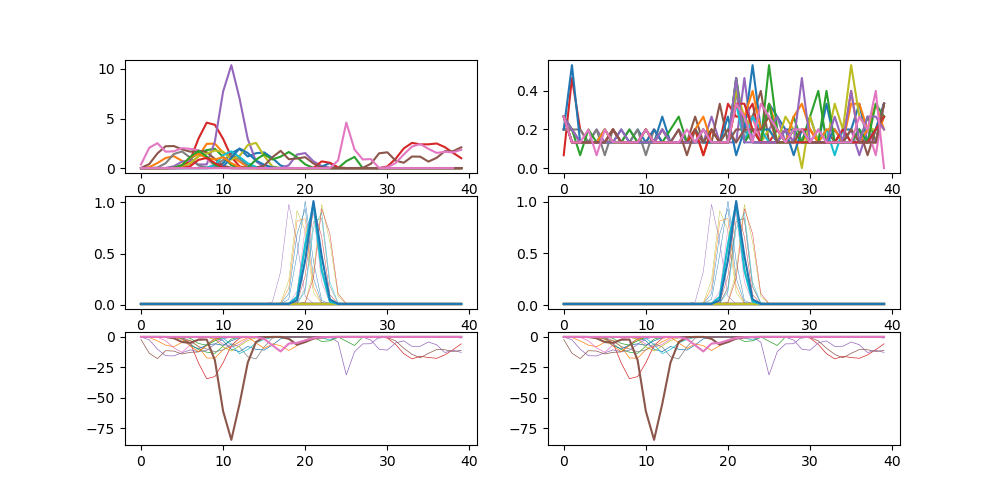

[-1617.08796928 -1617.10448248]


In [9]:
hbm = HierarchicalBayesModel(
    activity['trial_map'],
    behavior['trials']['dwelltime'],
    np.arange(nbin),
    logLevel=logging.DEBUG
)

my_prior_transform = hbm.transform_p
my_likelihood = hbm.set_logl_func()
#hbm.set_priors()
#print(hbm.priors)

p_in = np.random.rand(2,hbm.nPars)
p_transformed = my_prior_transform(p_in)
p_transformed[0,0] = 0.01
p_transformed[0,1] = 1
p_transformed[0,3] = 21
p_transformed[0,4] = 0
p_transformed[1,:] = p_transformed[0,:]
p_transformed[1,4] = 0.5


print(p_transformed)
logl = my_likelihood(p_transformed,plt_bool=True)
print(logl)

#%timeit my_prior_transform(p)
#%timeit my_likelihood(p_transformed)

In [7]:
hbm = HierarchicalBayesModel(
    activity['trial_map'],
    behavior['trials']['dwelltime'],
    np.arange(nbin),
    logLevel=logging.ERROR
)
p_cube = np.random.rand(2,hbm.nPars)
p_transformed = my_prior_transform(p_cube)
p_transformed
%timeit my_prior_transform(p_cube)
%timeit my_likelihood(p_transformed)

29 µs ± 450 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
238 µs ± 3.25 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
